In [1]:
import numpy as np
import mysql
import healpy, math
import copy
from itertools import combinations, chain
import matplotlib.pyplot as plt
from mysql.connector import Error
from astropy.table import QTable, Table, vstack, join, hstack
conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040)
cursor = conn.cursor(dictionary=True, buffered=True)
import _utils_extract_sources_in_cosmoDC2
import GCRCatalogs
import pickle
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
cosmodc2 = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image")
healpix_dc2 = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image").get_catalog_info()['healpix_pixels']
import sys
sys.path.append('../')
import _redshift_richness_bins as analysis

In [2]:
cosmodc2.sky_area

439.78987

In [3]:
path_to_data = '../../CLCosmo_Sim_database/data/'
name_lens_cat = path_to_data + 'lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl'
ra_name, dec_name, z_name = 'ra', 'dec', 'redshift'
obs_name = 'richness'
lens_cat = np.load(name_lens_cat, allow_pickle = True)
ra, dec, z, richness = lens_cat['ra'], lens_cat['dec'], lens_cat['redshift'], lens_cat['richness']
mask = (richness > 20) * (richness < 200) * (z > 0.2) * (z < 1)
ra, dec, z, richness = ra[mask], dec[mask], z[mask], richness[mask]

In [4]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
z_corner = analysis.z_corner#n
#z_corner = np.array([0.2, 0.4, 0.6, 0.8, 1])
Z_bin = binning(z_corner)
rich_corner = analysis.rich_corner
#rich_corner = np.array([20, 35, 70, 100, 200])
#rich_corner = np.array([r for r in rich_corner])
Obs_bin = binning(rich_corner)

In [5]:
n_density_redmapper = len(ra)/cosmodc2.sky_area

In [6]:
N, rich_edges, z_edges = np.histogram2d(z, richness,  bins = [z_corner, rich_corner, ])

In [7]:
n = 10000000
rand1 = np.random.random(n)
dec_deg_random = np.array([math.asin(2*n_ - 1) for n_ in rand1])*180/np.pi

In [8]:
mask_dec_random = (dec_deg_random < -20)*(dec_deg_random > -50)
dec_deg_random = dec_deg_random[mask_dec_random]
print(len(dec_deg_random))
rand2 = np.random.random(len(dec_deg_random))
ra_deg_random = rand2*(80 - 45) + 45
healpix_random = healpy.ang2pix(32, ra_deg_random, dec_deg_random, nest=False, lonlat=True)
mask_healpy_random = np.isin(healpix_random, healpix_dc2)
ra_random, dec_random = ra_deg_random[mask_healpy_random], dec_deg_random[mask_healpy_random]

2120793


In [9]:
n_density_random = len(ra_random)/439.78987

In [10]:
def cov_jaccknife(nside, cut_coverage=0.8, n_delete=1):
    healpix_list = np.unique(healpy.ang2pix(nside, ra_deg_random, dec_deg_random, nest=False, lonlat=True))
    #random on redmapper footprint
    healpix_random = healpy.ang2pix(nside, ra_random, dec_random, nest=False, lonlat=True)
    
    count_per_hp_random = np.array([len(healpix_random[healpix_random==p]) for p in healpix_list])
    density_per_hp = count_per_hp_random/healpy.nside2pixarea(nside, degrees=True)
    n_density_random = len(ra_random)/cosmodc2.sky_area
    coverage_hp = density_per_hp/n_density_random
    mask_healpix_used = coverage_hp > cut_coverage
    
    healpix_to_measure, index = np.unique(healpix_list[mask_healpix_used], return_index=True)
    coverage_to_measure = coverage_hp[mask_healpix_used]
    healpix_to_measure_comb = list(combinations(healpix_to_measure, n_delete))
    n_healpix = len(np.unique(healpix_to_measure))
    S_tot_healpix = n_healpix*healpy.nside2pixarea(nside, degrees=True)
    frac = S_tot_healpix/cosmodc2.sky_area
    
    healpix_redmapper_clusters = healpy.ang2pix(nside, ra, dec, nest=False, lonlat=True)
    histogram = np.zeros([len(z_corner)-1, len(rich_corner)-1, len(healpix_to_measure)])
    for i, p in enumerate(healpix_to_measure):
          histogram[:,:,i] =  np.histogram2d(z[np.isin(healpix_redmapper_clusters,p)],
                                      richness[np.isin(healpix_redmapper_clusters,p)], 
                                      bins=(z_corner, rich_corner),weights=None)[0]/frac
    pixeled_nc = np.zeros([len(healpix_to_measure_comb), (len(z_corner)-1)*(len(rich_corner)-1)])
    for j, p_comb in enumerate(healpix_to_measure_comb):
        index_healpix_to_keep = np.arange(len(healpix_to_measure))
        index_healpix_to_keep = index_healpix_to_keep[np.invert(np.isin(healpix_to_measure,p_comb))]
        histogram_JK = histogram[:,:,index_healpix_to_keep]
        pixeled_nc[j,:] = np.sum(histogram_JK, axis = 2).flatten()
    n_jack = len(healpix_to_measure_comb)
    n_s = len(healpix_to_measure)
    H = (n_jack - (len(z_corner)-1)*(len(rich_corner)-1) -2)/(n_jack-1)
    print(H)
    coeff = (n_s - n_delete)/(n_delete*n_jack)
    cov_n = coeff * np.cov(np.transpose(pixeled_nc), bias=False) * (n_jack - 1) 
    cov_N =  cov_n# / H
    return cov_N

In [11]:
cov16 =cov_jaccknife(16, cut_coverage=.92, n_delete=2)

0.9104938271604939


In [12]:
cov32 =cov_jaccknife(32, cut_coverage = .95, n_delete=2)

0.9965938454310548


In [13]:
cov64 = cov_jaccknife(64, cut_coverage=0.7, n_delete=1)

0.9445506692160612


In [14]:
cov128 = cov_jaccknife(128, cut_coverage=0.7, n_delete=1)

0.9861575178997614


In [15]:
%load_ext autoreload
%autoreload 2
import clmm
import pyccl as ccl
from clmm import Cosmology
sys.path.append('../modeling/')
import CL_COUNT_modeling_completeness as comp
import CL_COUNT_modeling_purity as pur
import CL_COUNT_modeling_halo_mass_function as hmf
import CL_COUNT_modeling_richness_mass_relation as rm_relation
import CL_MASS_cluster_mass as cl_mass
import CL_COUNT_cluster_abundance as cl_count
import CL_LENSING_cluster_lensing as cl_lensing
sys.path.append('/pbs/throng/lsst/users/cpayerne/PySSC/')
import PySSC
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import covariance as covar

In [16]:
#cosmology
Omega_c_true = 0.2648 - 0.0448
Omega_b_true = 0.0448
sigma8_true = .8
Omegam_true = 0.2648
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.2648 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 71/100, sigma8 = sigma8_true, n_s=0.963)
#halo model
massdef = ccl.halos.massdef.MassDef(200, 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)

In [17]:
#purity
a_nc, b_nc, a_rc, b_rc = np.log(10)*0.8612, np.log(10)*0.3527, 2.2183, -0.6592
theta_purity = [a_nc, b_nc, a_rc, b_rc]
#completeness
a_nc, b_nc, a_mc, b_mc = 1.1321, 0.7751, 13.31, 0.2025
theta_completeness = [a_nc, b_nc, a_mc, b_mc]
#rm_relation
log10m0, z0 = np.log10(10**14.3), .5
proxy_mu0, proxy_muz, proxy_mulog10m =  3.14511557, -0.0435828,   2.04626608
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  0.63992348,  0.29677146, -0.02426758
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

In [18]:
richness_grid = np.logspace(np.log10(20), np.log10(200), 310)
logm_grid = np.linspace(11, 16, 200)
z_grid = np.linspace(.2, 1, 301)

In [19]:
bins = {'redshift_bins':Z_bin, 'richness_bins': Obs_bin}
grids = {'logm_grid': logm_grid, 'z_grid': z_grid, 'richness_grid':richness_grid}
count_modelling = {'dNdzdlogMdOmega':None,'richness_mass_relation':None, 'completeness':None, 'purity':None }
params = {'params_purity':theta_purity, 'params_completeness': theta_completeness, 'params_richness_mass_relation': theta_rm,
         'CCL_cosmology': cosmo, 'halo_mass_distribution': hmd, 'params_concentration_mass_relation': 'Duffy08'}
adds = {'add_purity' : True, 'add_completeness':True}
compute = {'compute_dNdzdlogMdOmega':True,'compute_richness_mass_relation':True, 
           'compute_completeness':True, 'compute_purity':True, 'compute_halo_bias':True }
#compute_count_modeling
%time count_modelling_new = cl_count.recompute_count_modelling(count_modelling, grids = grids, compute = compute, params = params)
integrand_count = cl_count.define_count_integrand(count_modelling_new, adds)
Omega = (4*np.pi)*(439.78987/(360**2/np.pi))
Nth = Omega * cl_count.Cluster_SurfaceDensity_ProxyZ(bins, integrand_count = integrand_count, grids = grids)

CPU times: user 7.49 s, sys: 510 ms, total: 8 s
Wall time: 4.13 s


In [20]:
bNth = Omega * cl_count.Cluster_NHaloBias_ProxyZ(bins, integrand_count = integrand_count, halo_bias = count_modelling_new['halo_bias'], grids = grids, cosmo = cosmo)

In [21]:
default_cosmo_params = {'omega_b':cosmo['Omega_b']*cosmo['h']**2, 
                                'omega_cdm':cosmo['Omega_c']*cosmo['h']**2, 
                                'H0':cosmo['h']*100, 
                                'n_s':cosmo['n_s'], 
                                'sigma8': cosmo['sigma8'],
                                'output' : 'mPk'}
z_arr = np.linspace(0.2,1.2,1000)
nbins_T   = len(Z_bin)
windows_T = np.zeros((nbins_T,len(z_arr)))
for i, z_bin in enumerate(Z_bin):
    Dz = z_bin[1]-z_bin[0]
    z_arr_cut = z_arr[(z_arr > z_bin[0])*(z_arr < z_bin[1])]
    for k, z in enumerate(z_arr):
        if ((z>z_bin[0]) and (z<=z_bin[1])):
            windows_T[i,k] = 1  
Sij_fullsky = PySSC.Sij_alt_fullsky(z_arr, windows_T, order=1, cosmo_params=default_cosmo_params, cosmo_Class=None, convention=0)

In [22]:
f_sky = (439.78987/(360**2/np.pi))
Sij_partialsky = Sij_fullsky/f_sky

In [23]:
Covariance = covar.Covariance_matrix()
NNSbb = Covariance.sample_covariance_full_sky(Z_bin, Obs_bin, 
                                                  bNth.T, 
                                                  Sij_partialsky)

In [24]:
cov_tot = NNSbb + np.diag(Nth.T.flatten())

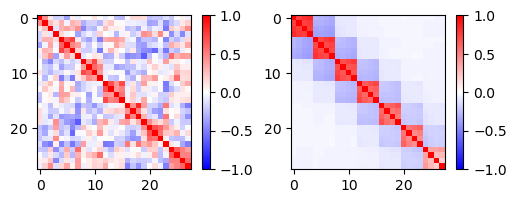

In [27]:
plt.figure(figsize=(6, 2))
plt.subplot(121)
plt.imshow(np.corrcoef(cov32), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()
plt.subplot(122)
plt.imshow(np.corrcoef(np.diag(Nth.T.flatten())+NNSbb), cmap='bwr', vmin=-1, vmax=1)
plt.colorbar()

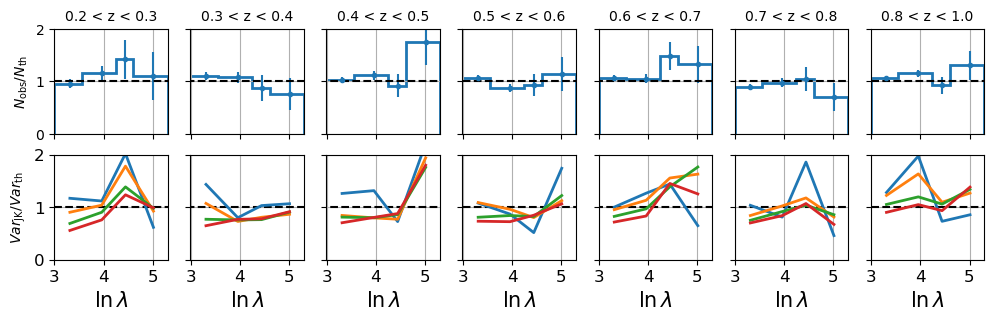

In [28]:
fig, ax = plt.subplots(2, len(Z_bin), figsize=(12,3), sharex = True, sharey = True)
for i, z_bin in enumerate(Z_bin):
        z0 = z_bin[0]
        z1 = z_bin[1]
        ax[0,i].set_title(f'{z0:.1f} < z < {z1:.1f}', fontsize=10)
        Varth = Nth[:,i]+NNSbb.diagonal()[i*4:(i+1)*4]
        x = np.linspace(-20, 1000, 100)
        ax[0,i].errorbar(np.log(np.mean(Obs_bin, axis=1)), N.T[:,i]/Nth[:,i] ,
                       N.T[:,i]**.5/Nth[:,i], fmt=' ', marker = '.')
        ax[0,i].stairs(N.T[:,i]/Nth[:,i], np.log(rich_corner), lw=2, color='C0')
        ax[0,0].set_ylabel(r'$N_{\rm obs}/N_{\rm th}$')
        ax[1,0].set_ylabel(r'$Var_{\rm JK}/Var_{\rm th}$')
        ax[0,i].plot(x, 0*x +1, '--k')
        ax[1,i].plot(x, 0*x +1, '--k')
        ax[1,i].errorbar(np.log(np.mean(Obs_bin, axis=1)),cov16.diagonal()[i*4:(i+1)*4]/Varth, label = r'nside=16', lw=2)
        ax[1,i].errorbar(np.log(np.mean(Obs_bin, axis=1)),cov32.diagonal()[i*4:(i+1)*4]/Varth,  label = r'nside=32', lw=2)
        ax[1,i].errorbar(np.log(np.mean(Obs_bin, axis=1)),cov64.diagonal()[i*4:(i+1)*4]/Varth,  label = r'nside=64', lw=2)
        ax[1,i].errorbar(np.log(np.mean(Obs_bin, axis=1)),cov128.diagonal()[i*4:(i+1)*4]/Varth, label = r'nside=128', lw=2)
        ax[1,i].set_xlabel(r'$\ln\lambda$', fontsize=15)
        #ax[1,3].legend(fontsize=10, frameon=True,ncols=3, loc = 'upper right')
        ax[1,i].set_ylim(0., 2)
        ax[1,i].set_xlim(np.log(rich_corner[0]), np.log(rich_corner[-1]))
        ax[1,i].tick_params(axis='both', which="both", labelsize= 12)
        ax[1,i].grid(True,which='both')
        ax[0,i].grid(True,which='both')
plt.savefig('../fig/covariance_JK_vs_th.png', bbox_inches='tight', dpi=150)

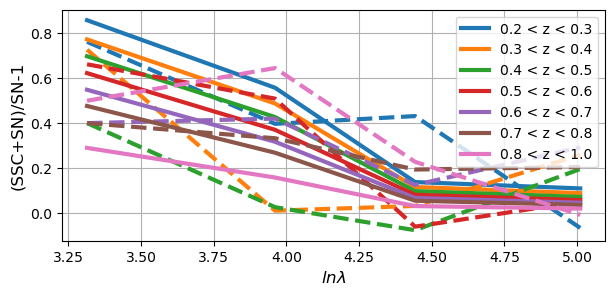

In [ ]:
plt.figure(figsize=(7,3))
for i, z_bin in enumerate(Z_bin):
    z0 = z_bin[0]
    z1 = z_bin[1]
    Varth = Nth[:,i]+NNSbb.diagonal()[i*4:(i+1)*4]
    Varth_SN = Nth[:,i]
    Varth_SSC = NNSbb.diagonal()[i*4:(i+1)*4]
    x = np.linspace(-20, 1000, 100)
    plt.plot(np.log(np.mean(Obs_bin, axis=1)), Varth/Varth_SN-1, label = f'{z0:.1f} < z < {z1:.1f}', lw=3, color = 'C'+str(i))
    plt.plot(np.log(np.mean(Obs_bin, axis=1)), cov32.diagonal()[i*4:(i+1)*4]/ N.T[:,i]-1, '--', lw=3, color = 'C'+str(i), )
plt.grid()
plt.ylabel('(SSC+SN)/SN-1', fontsize=12)
plt.xlabel(r'$ln \lambda$', fontsize=12)
plt.legend()